<a href="https://colab.research.google.com/github/MarjanNur/it-cert-automation-practice/blob/master/Module4_Lesson1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gradient Boosting

![](https://drive.google.com/uc?export=view&id=1Uk7jBQsV2gBwRIScKFlXzKvT-j2P-s3Y)

## Decision Tree vs Gradient Boosting Trees vs Random Forest

![](https://drive.google.com/uc?export=view&id=1FlQIIoOYpLRdKlMDRCJIFDKd_8l5C4U_)

![](https://drive.google.com/uc?export=view&id=1mzOyeksEWExV2OgVfJjJ7Nq2icXtf2uI)

В случае же бустинга каждый алгоритм настраивается на ошибки всех предыдущих, это позволяет на каждом шаге настраиваться на исходное распределение все точнее и точнее. Однако при достаточно большом
 это является источником переобучения, поскольку последующие добавления новых алгоритмов будут продолжать настраиваться на обучающую выборку, уменьшая ошибку на ней, при этом уменьшая обобщающую способность итоговой композиции.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

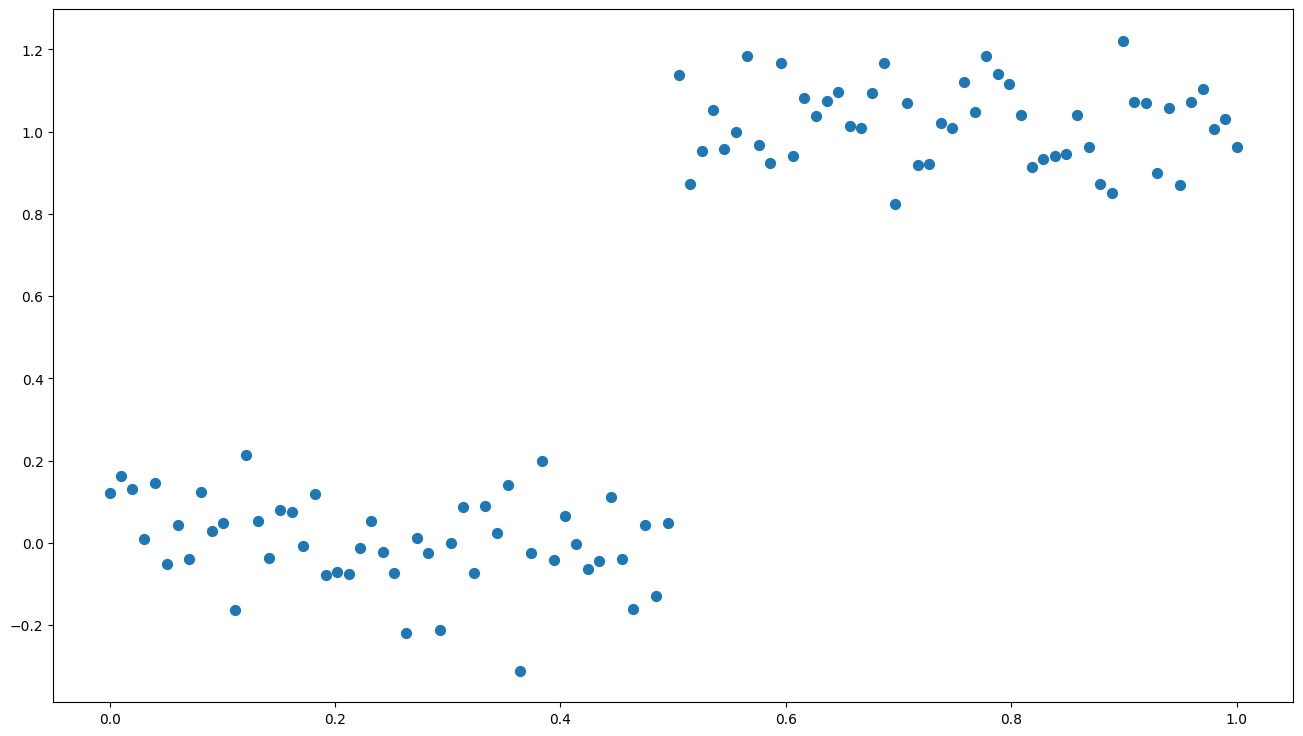

In [ ]:
X_train = np.linspace(0, 1, 100)
X_test = np.linspace(0, 1, 1000)

@np.vectorize
def target(x):
    return x > 0.5

Y_train = target(X_train) + np.random.randn(*X_train.shape) * 0.1

plt.figure(figsize = (16, 9))
plt.scatter(X_train, Y_train, s=50)

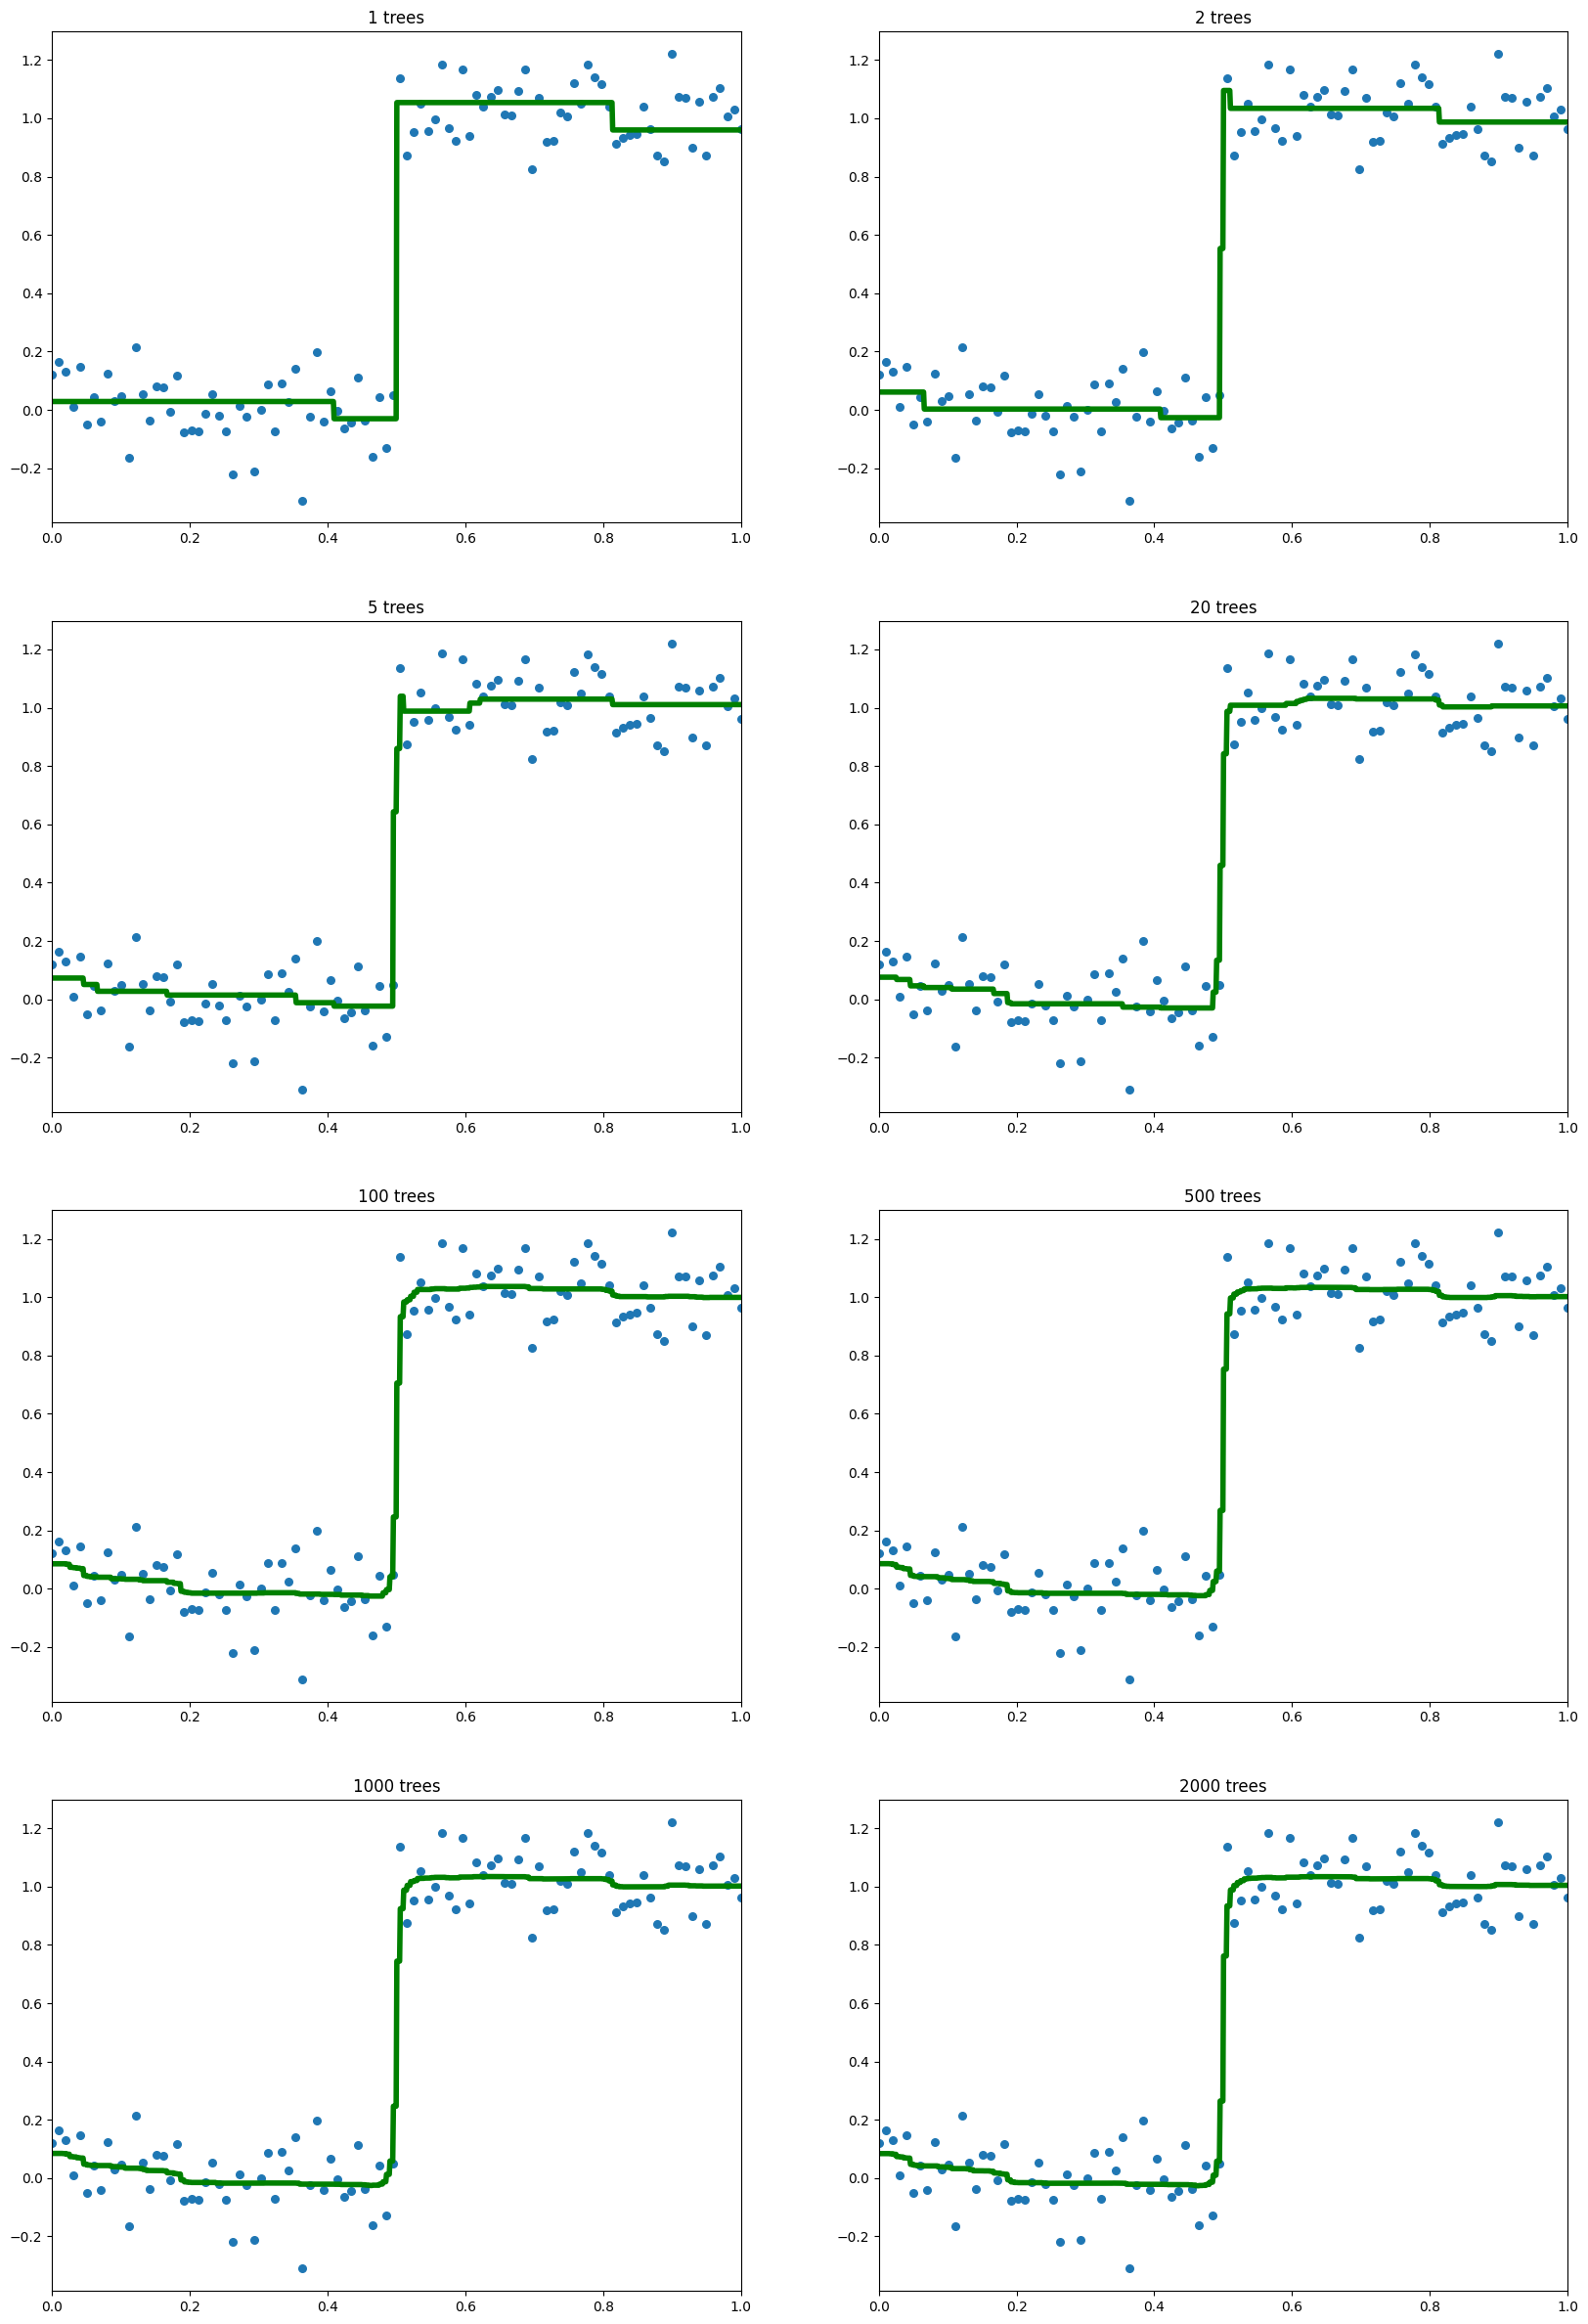

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor

reg = BaggingRegressor(DecisionTreeRegressor(max_depth=2), warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Можно заметить, что с некоторого момента итоговая функция перестает меняться с ростом количества деревьев.

Теперь проделаем то же самое для градинентного бустинга.

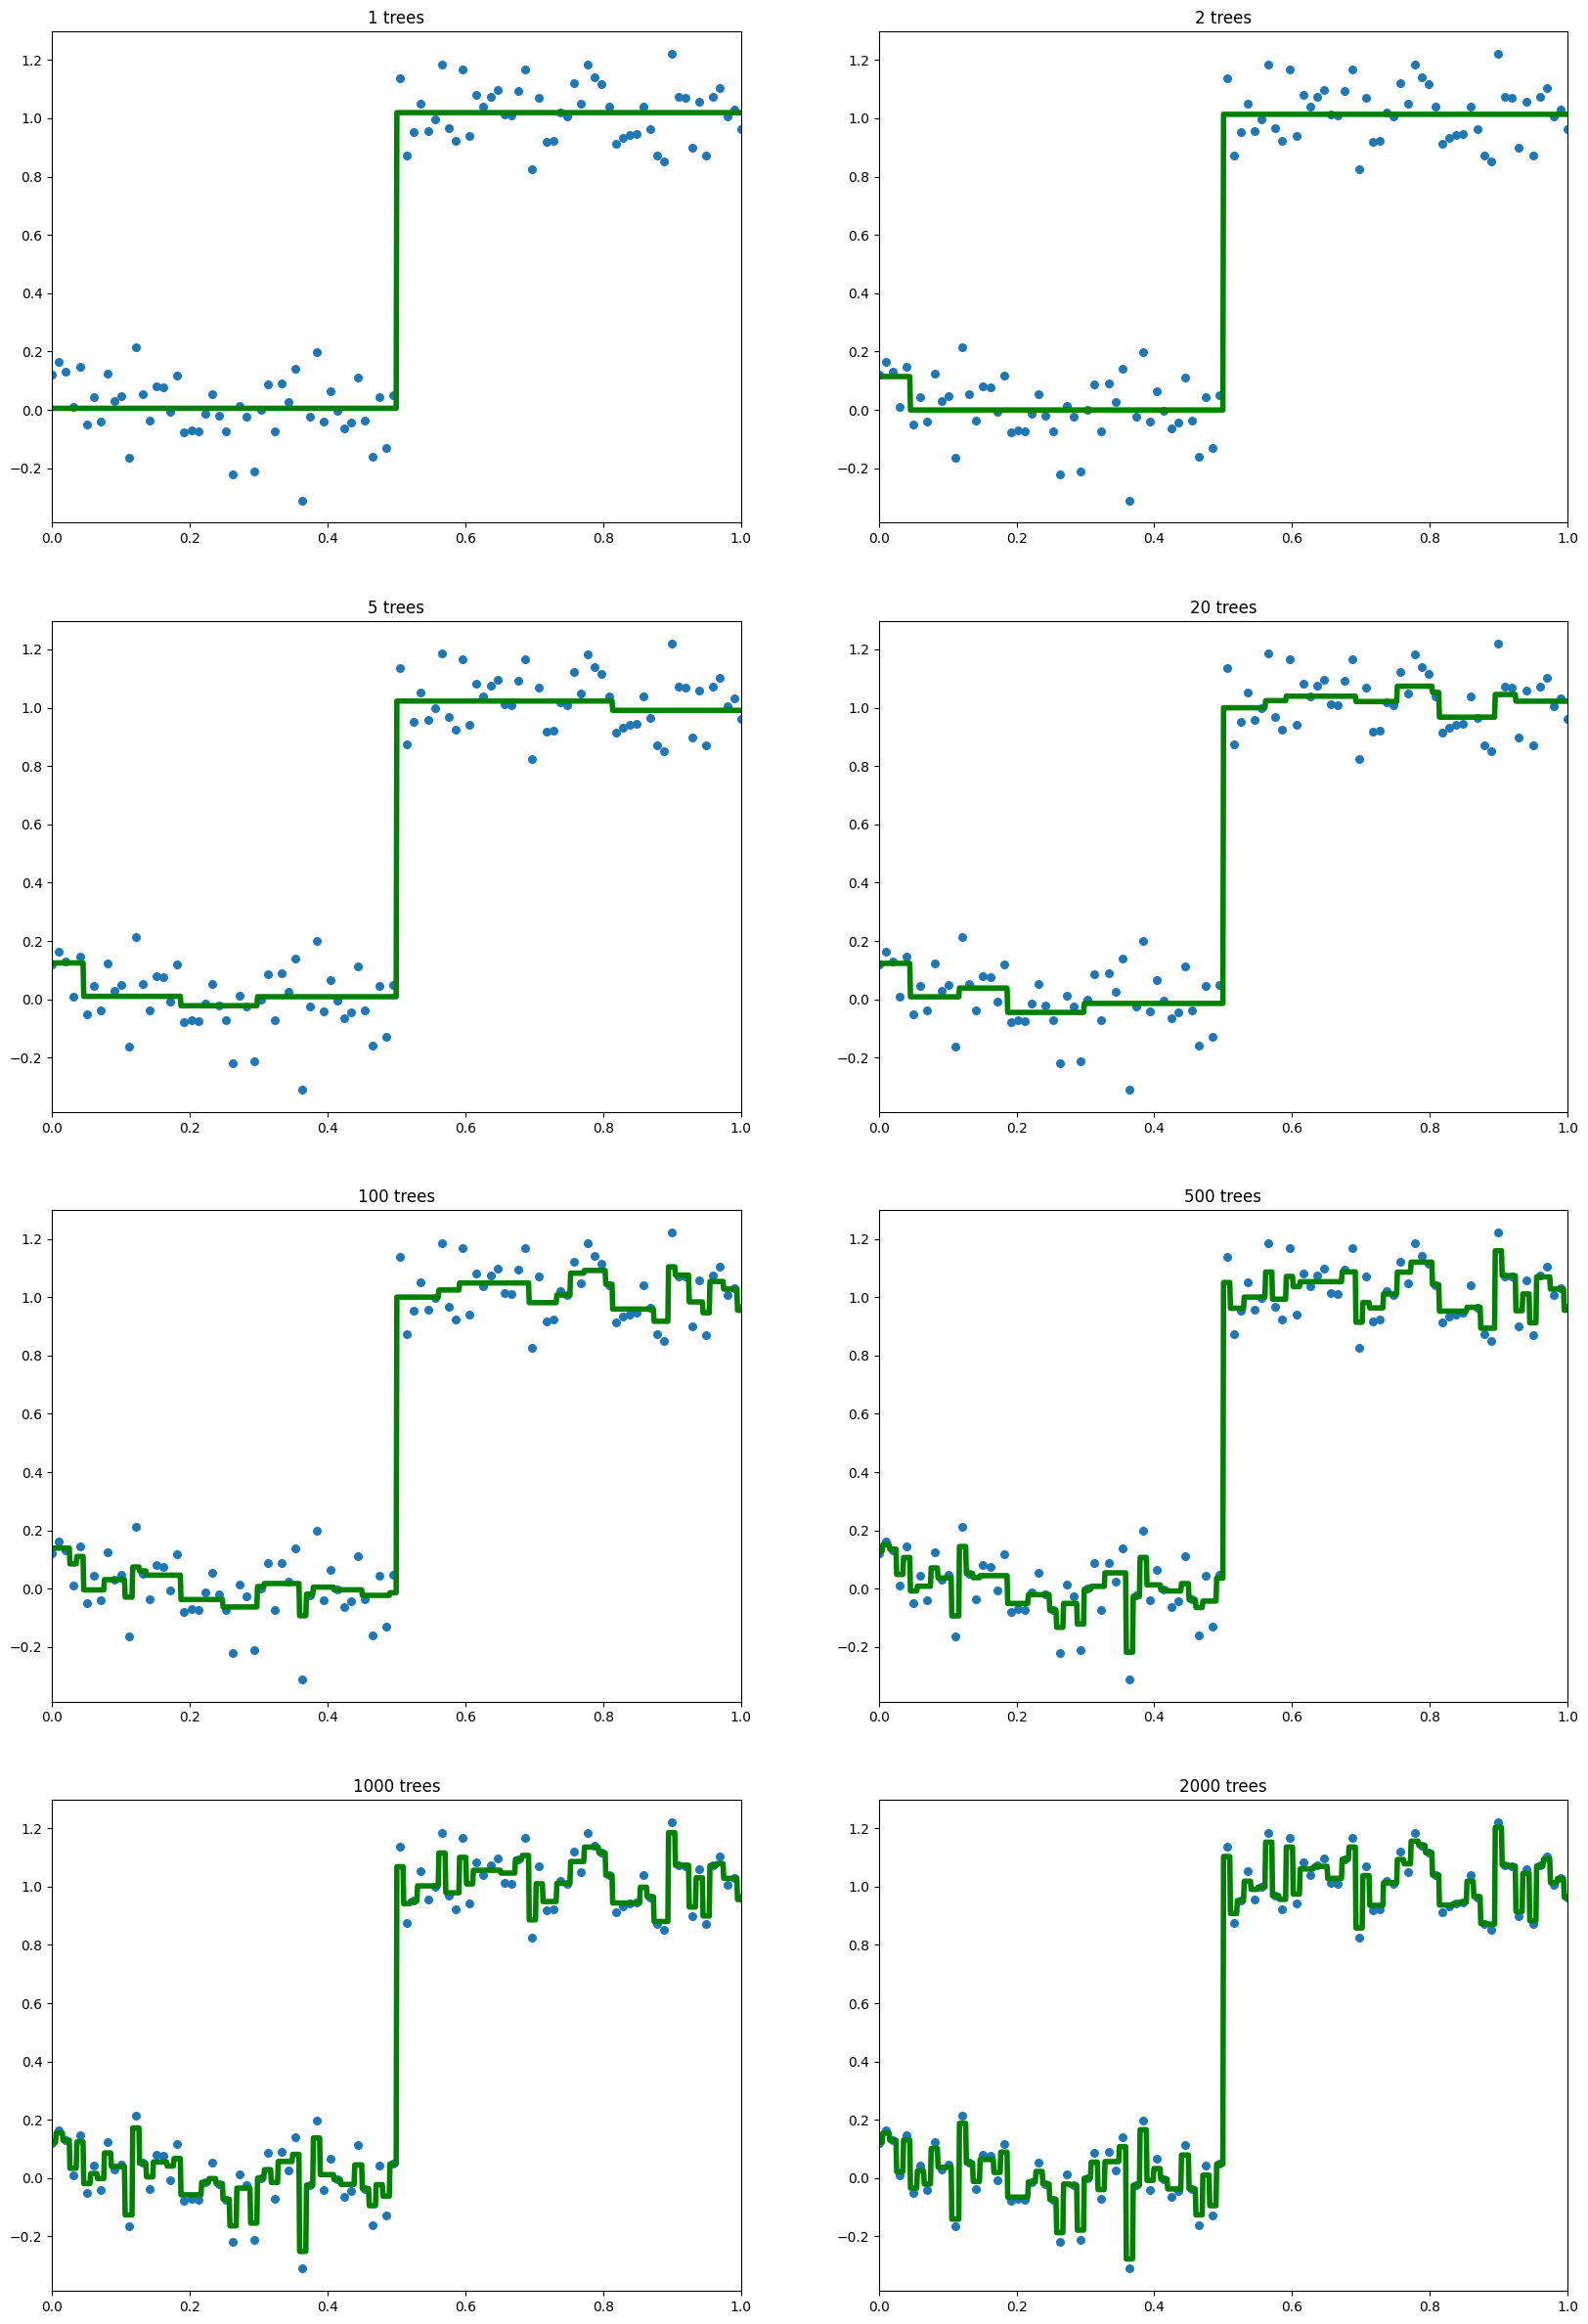

In [ ]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=1, warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Градиентный бустинг довольно быстро построил истинную зависимость, после чего начал настраиваться уже на конкретные объекты обучающей выборки, из-за чего сильно переобучился.

Бороться с этой проблемой можно с помощью выбора очень простого базового алгоритма или же искусственным снижением веса новых алгоритмов при помощи шага $\eta$:
$$a_N(x) = \sum_{n=0}^N \eta \gamma_N b_n(x).$$
Такая поправка замедляет обучение по сравнению с бэггингом, но зато позволяет получить менее переобученный алгоритм. Тем не менее, важно понимать, что переобучение всё равно будет иметь место при обучении сколь угодно большого количества базовых алгоритмов для фиксированного $\eta$.

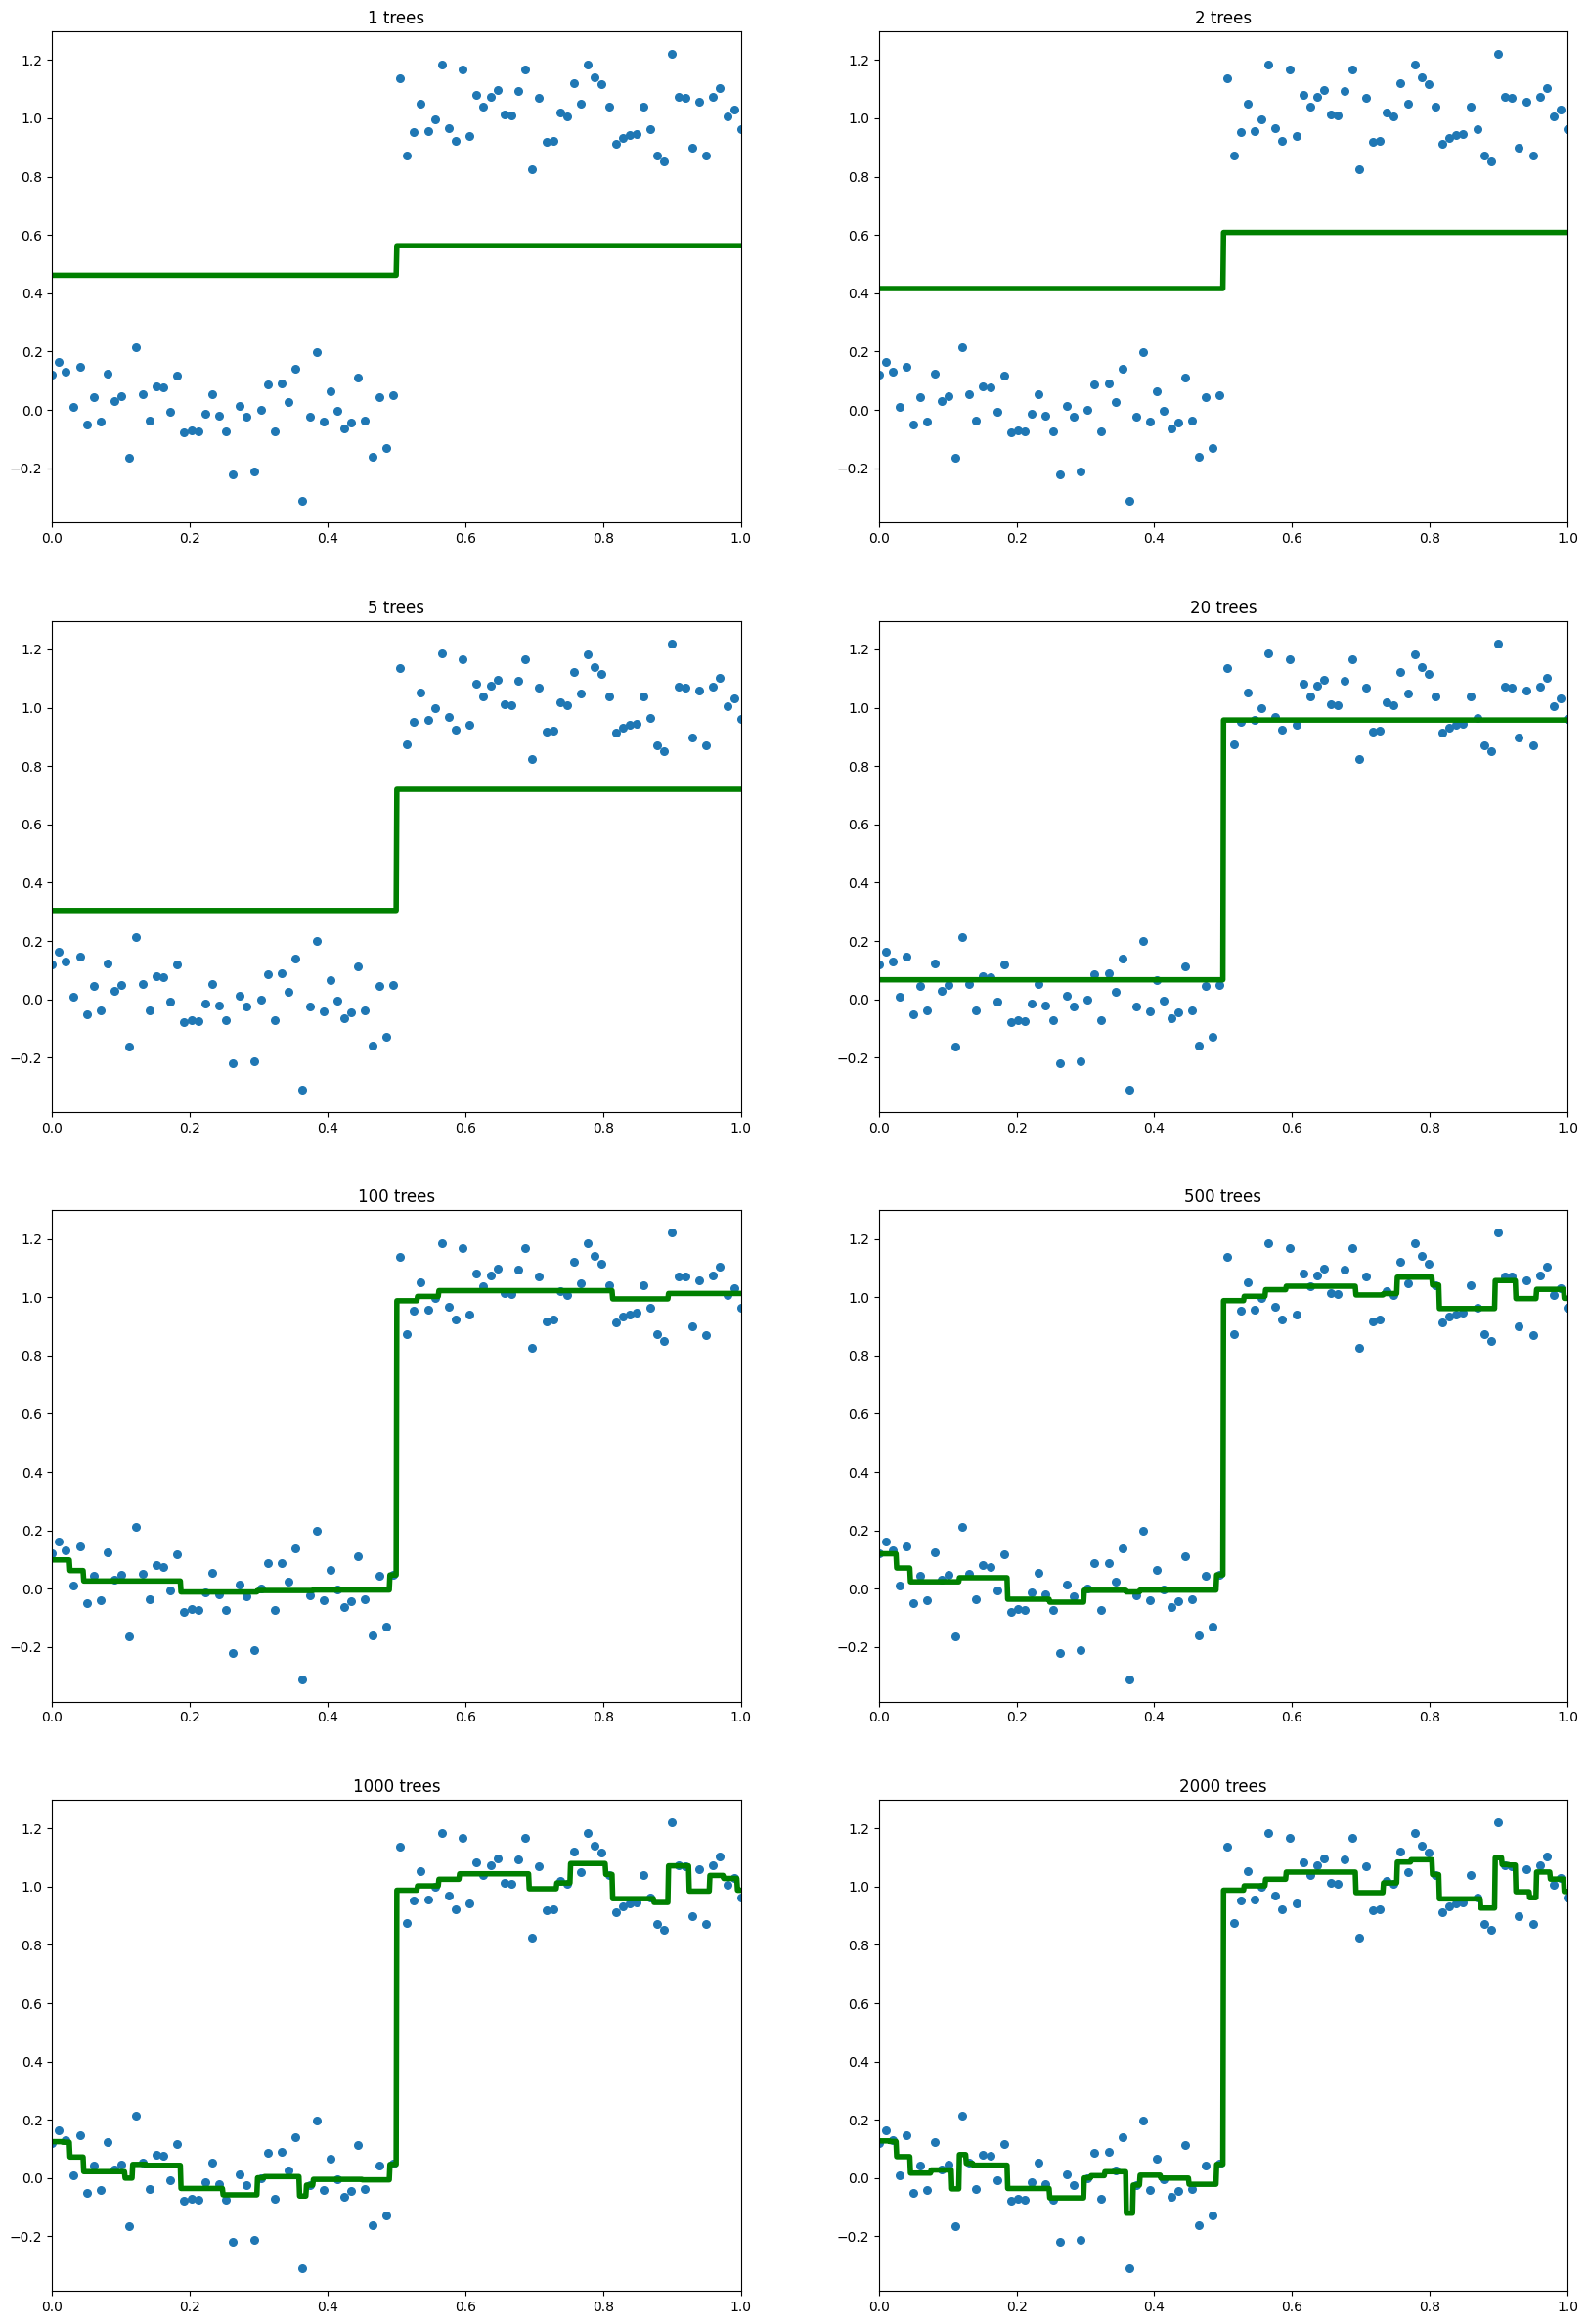

In [ ]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=0.1, warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Теперь проверим описанный выше эффект на реальных данных.

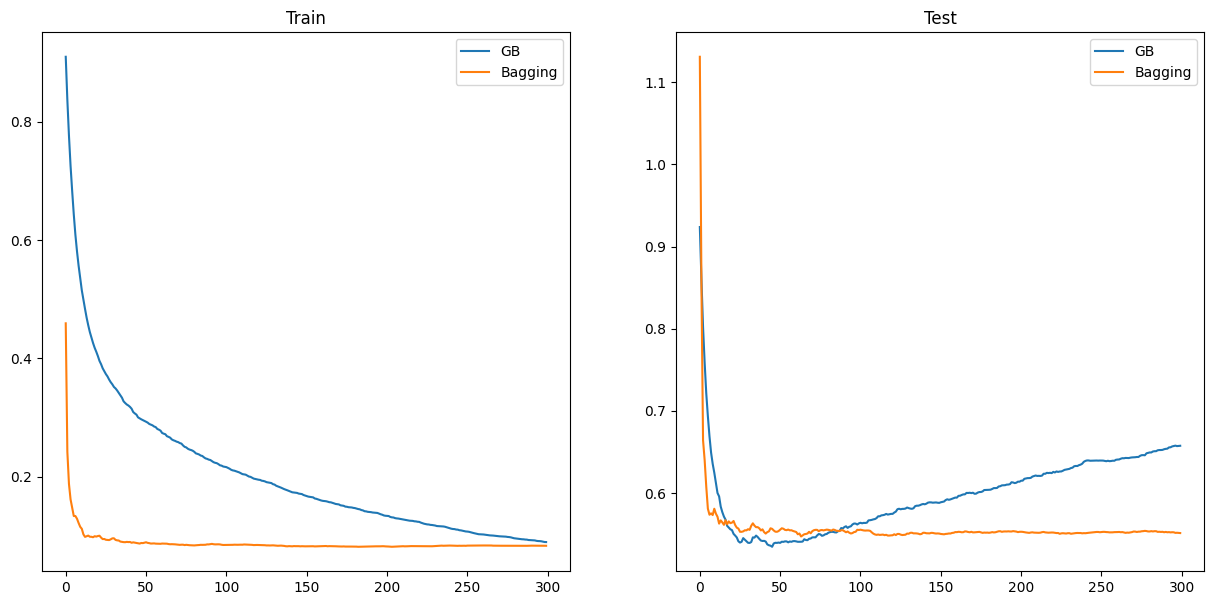

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

ds = datasets.load_diabetes()
X = ds.data
Y = ds.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.5, test_size=0.5)

MAX_ESTIMATORS = 300

gbclf = BaggingRegressor(warm_start=True)
err_train_bag = []
err_test_bag = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_bag.append(1 - gbclf.score(X_train, Y_train))
    err_test_bag.append(1 - gbclf.score(X_test, Y_test))

gbclf = GradientBoostingRegressor(warm_start=True, max_depth=2, learning_rate=0.1)
err_train_gb = []
err_test_gb = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_gb.append(1 - gbclf.score(X_train, Y_train))
    err_test_gb.append(1 - gbclf.score(X_test, Y_test))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(err_train_gb, label='GB')
plt.plot(err_train_bag, label='Bagging')
plt.legend()
plt.title('Train')
plt.subplot(1, 2, 2)
plt.plot(err_test_gb, label='GB')
plt.plot(err_test_bag, label='Bagging')
plt.legend()
plt.title('Test')
plt.gcf().set_size_inches(15,7)